In [116]:
import torch 
import torch.nn as nn 
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision

import matplotlib.pyplot as plt
import numpy as np 

In [117]:
device = None 
if torch.cuda.is_available(): 
    device = "cuda"
else: 
    device = "cpu"

In [118]:
transform = {
    "train" : transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]), 
    "val" : transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.5,), (0.5,))
    ])
}

In [119]:
batch_size = 4

In [120]:
train_ds = datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform["train"])


val_ds = datasets.CIFAR100(root='./data', train=False,
                                        download=True, transform=transform["val"])

Files already downloaded and verified
Files already downloaded and verified


In [139]:
classes = [str(x) for x in range(101)]
print(classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100']


In [121]:
train_size = train_ds.data.shape
val_size = val_ds.data.shape

print("train :", train_size)
print("val :", val_size)

train : (50000, 32, 32, 3)
val : (10000, 32, 32, 3)


In [122]:
train_ds = torch.utils.data.DataLoader(
    train_ds, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4
)

val_ds = torch.utils.data.DataLoader(
    val_ds, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4
)

['_DataLoader__initialized',
 '_DataLoader__multiprocessing_context',
 '_IterableDataset_len_called',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_collation',
 '_dataset_kind',
 '_get_iterator',
 '_index_sampler',
 '_iterator',
 'batch_sampler',
 'batch_size',
 'check_worker_number_rationality',
 'collate_fn',
 'dataset',
 'drop_last',
 'generator',
 'multiprocessing_context',
 'num_workers',
 'persistent_workers',
 'pin_memory',
 'prefetch_factor',
 'sampler',
 'timeout',
 'worker_init_fn']

In [ ]:
data = iter(train_ds)
inputs, labels = data.next()

In [124]:
def plot_image(inp, title=None):
    if title is not None: 
        plt.title(f"label : {title}") 
    
    inp = inp.numpy()
    inp = np.transpose(inp, (1, 2, 0))
    inp = inp * 0.5 + 0.5
    plt.imshow(inp)
    return plt.show()


In [125]:
grid = torchvision.utils.make_grid(inputs)

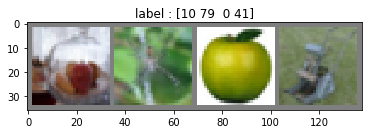

In [126]:
plot_image(grid, labels.numpy())

In [127]:
import torch.nn.functional as F


In [156]:
class ResidualBlock(nn.Module): 
    
    def __init__(self, output_filter,prev_filter, downsample=False): 
        super(ResidualBlock, self).__init__()
        self.downsample = downsample
        self.prev_filter = prev_filter
        self.conv_down = None
        stride = None
        if downsample: 
            stride = 2 
            self.conv_down = torch.nn.Conv2d(prev_filter, output_filter, 1, stride=stride)
        else: 
            stride = 1
        
        self.output_filter = output_filter
        self.conv1 = torch.nn.Conv2d(prev_filter, output_filter, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(output_filter, output_filter, 3, stride=stride, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_filter)
        self.bn2 = torch.nn.BatchNorm2d(output_filter)
        
        
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.downsample: 
            inputs = self.conv_down(inputs)
            inputs = self.bn1(inputs)    
        x = F.relu(inputs + x)
        return x

In [157]:
from torchsummary import summary

block = ResidualBlock(56, 56, downsample=True)
block.to(device)
summary(block, batch_size=batch_size, input_size=(56, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 56, 32, 32]          28,280
       BatchNorm2d-2            [4, 56, 32, 32]             112
            Conv2d-3            [4, 56, 16, 16]          28,280
       BatchNorm2d-4            [4, 56, 16, 16]             112
            Conv2d-5            [4, 56, 16, 16]           3,192
       BatchNorm2d-6            [4, 56, 16, 16]             112
Total params: 60,088
Trainable params: 60,088
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.88
Forward/backward pass size (MB): 5.25
Params size (MB): 0.23
Estimated Total Size (MB): 6.35
----------------------------------------------------------------


In [158]:
class ResidualLayer(nn.Module): 
    
    def __init__(self, filter_list, prev_filter, stride=1): 
        super(ResidualLayer, self).__init__()
        self.prev_filter = prev_filter
        self.filter_list = filter_list
        self.stride = stride
        self.layers = self.build_layer()
            
    def build_layer(self): 
        layers = []
        for i in range(len(self.filter_list)): 
            if i == 0 and self.stride == 2: 
                layers.append(ResidualBlock(self.filter_list[i], self.prev_filter, downsample=True))
                self.prev_filter = self.filter_list[i]
            else: 
                layers.append(ResidualBlock(self.filter_list[i], self.prev_filter)) 
                                   
        return nn.Sequential(*layers)
                                   
    def forward(self, x): 
        for layer in self.layers: 
            x = layer(x)
        return x

In [159]:
layer = ResidualLayer([128, 128], 64, stride=2)
layer.to(device)
summary(layer, batch_size=batch_size, input_size=(64, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [4, 128, 32, 32]          73,856
       BatchNorm2d-2           [4, 128, 32, 32]             256
            Conv2d-3           [4, 128, 16, 16]         147,584
       BatchNorm2d-4           [4, 128, 16, 16]             256
            Conv2d-5           [4, 128, 16, 16]           8,320
       BatchNorm2d-6           [4, 128, 16, 16]             256
     ResidualBlock-7           [4, 128, 16, 16]               0
            Conv2d-8           [4, 128, 16, 16]         147,584
       BatchNorm2d-9           [4, 128, 16, 16]             256
           Conv2d-10           [4, 128, 16, 16]         147,584
      BatchNorm2d-11           [4, 128, 16, 16]             256
    ResidualBlock-12           [4, 128, 16, 16]               0
Total params: 526,208
Trainable params: 526,208
Non-trainable params: 0
-------------------------------

In [160]:
class TinyResnet(nn.Module): 
    
    def __init__(self): 
        super(TinyResnet, self).__init__() 
        self.conv1 = torch.nn.Conv2d(3, 128, 7, stride=2)
        self.pool1 = torch.nn.MaxPool2d(2, stride=2)
        self.bn1 = torch.nn.BatchNorm2d(128)
        
        self.block1 = ResidualLayer([128, 128], 128)
        self.block2 = ResidualLayer([128, 128], 128)
        self.block3 = ResidualLayer([256, 256], 128, stride=2)
                
        self.avg_pool = torch.nn.AvgPool2d(3)
        self.fc1 = torch.nn.Linear(256, 101)
        
    def forward(self, x): 
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        
        x = self.avg_pool(x).squeeze()
        x = self.fc1(x)
        
        return x

In [161]:
resnet = TinyResnet()
resnet.to(device)
summary(resnet, batch_size=batch_size, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [4, 128, 13, 13]          18,944
       BatchNorm2d-2           [4, 128, 13, 13]             256
         MaxPool2d-3             [4, 128, 6, 6]               0
            Conv2d-4             [4, 128, 6, 6]         147,584
       BatchNorm2d-5             [4, 128, 6, 6]             256
            Conv2d-6             [4, 128, 6, 6]         147,584
       BatchNorm2d-7             [4, 128, 6, 6]             256
     ResidualBlock-8             [4, 128, 6, 6]               0
            Conv2d-9             [4, 128, 6, 6]         147,584
      BatchNorm2d-10             [4, 128, 6, 6]             256
           Conv2d-11             [4, 128, 6, 6]         147,584
      BatchNorm2d-12             [4, 128, 6, 6]             256
    ResidualBlock-13             [4, 128, 6, 6]               0
    ResidualLayer-14             [4, 12